In [1]:
import warnings
from collections import namedtuple
from math import ceil

warnings.simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from algorithms.snn import SNN
from algorithms.snn_biclustering import SNNBiclustering
from algorithms.fill_tensor_ALS import ALS
from sklearn.metrics import r2_score
import time
from synthetic_data_generation.generate_eval import (
    sales_data_staggering_assignment,
    sales_data_si_assignment,
    sales_data_random_assignment,
    get_sales_data,
)

Metric = namedtuple(
    "Metric",
    "train_time  query_time r2 mse number_estimated_entries number_estimated_feasible_entries",
)
ALG_REGISTRY = {"SNN": SNN, "SNNBiclustering": SNNBiclustering, "ALS": ALS}




In [2]:

def evaluate_partial(
    data_gen,
    data_assignment,
    algorithm,
    repeat,
    datasize,
    chunk_size,
    drifts = None,
    same_sub_space_regimes = False,
    no_units = 100
):
    # get indices to adjust tensor
    no_batches = ceil((datasize) / chunk_size)
    scores = np.zeros([no_batches, repeat])
    np.random.seed(0)
    for i in range(repeat):
        data = data_gen(seed=i, N=no_units, T=datasize, drifts = drifts, same_sub_space_regimes = same_sub_space_regimes)
        if i != 0:
            if algorithm == "SNN":
                model._get_anchors.cache.clear()
                model._get_beta.cache.clear()
            elif algorithm == "SNNBiclustering":
                model._map_missing_value.cache.clear()
                model._get_beta_from_factors.cache.clear()
        model = ALG_REGISTRY[algorithm](verbose=False, full_training_time_steps = 100)
        start = 0
        for batch in range(no_batches):
            end = min(start + chunk_size - 1, datasize - 1)
            batch_tensor, full_df = data.generate([start, end])
            periods = data_assignment(data, seed= (no_batches +i) + batch, T=end - start + 1)
            
            ss_tensor, df_batch = data.auto_subsample(periods, batch_tensor, full_df)
            batch_mask = data.mask

            batch_mask = batch_mask.astype(bool)
            t = time.perf_counter()
            if batch == 0:
                mask = batch_mask.copy()
                tensor = batch_tensor.copy()
                model.fit(
                    df=df_batch,
                    unit_column="unit_id",
                    time_column="time",
                    metrics=["sales"],
                    actions=["ads"],
                )
                indices = [model.actions_dict[action] for action in ["ad 0", "ad 1", "ad 2"]]

            else:
                mask = np.concatenate([mask, batch_mask], axis=1)
                tensor = np.concatenate([tensor, batch_tensor], axis=1)
                model.partial_fit(df_batch)
            
            print(model.regimes, [(regime.start_time, regime.mean_drift) for regime in model.regimes], len(model.cusum))
            print([m.shape for m in model.regimes[0].tensor_cp_factors])
            unit_idx = np.arange(no_units).astype(int)
            _tensor_est = model.query_tensor(unit_idx = unit_idx, time_idx = list(range(end+1)), )
            tensor_est = _tensor_est[:, :, indices]
            notnan = ~np.isnan(tensor_est)
            tensor_true = tensor[:,:end+1,:,0]
            mask_t = mask[:,:end+1,:,0]
            estimate = tensor_est[notnan][~mask_t[notnan]].flatten()
            if len(tensor_est[notnan][~mask_t[notnan]].flatten()) > 0:
                score = r2_score(
                tensor_true[notnan][~mask_t[notnan]].flatten(),
                estimate,
            )
            else: 
                score = 0
            scores[batch, i] = score
        
            start = end + 1

    return scores, model, model.cusum

## Evaluate WIE with drift

In [3]:

# data examples
datasets_assignment_generators = [
    sales_data_si_assignment,
    sales_data_staggering_assignment,
    sales_data_random_assignment,
]
data_names = ["SI sparsity", "staggered", "random"]
num_datasets = len(datasets_assignment_generators)
data_gen = get_sales_data

### 1. No drift, small chunk updates

Generated 113 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12a3a0a60>] [(0, 0.009613233585849307)] 10
[(100, 5), (10, 5), (3, 5)]
Generated 195 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12a3a0a60>] [(0, 0.008577114292518534)] 20
[(100, 5), (20, 5), (3, 5)]
Generated 296 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12a3a0a60>] [(0, 0.008727525303411284)] 30
[(100, 5), (30, 5), (3, 5)]
Generated 365 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12a3a0a60>] [(0, 0.009382501733025721)] 40
[(100, 5), (40, 5), (3, 5)]
Generated 374 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12a3a0a60>] [(0, 0.009902230827152502)] 50
[(100, 5), (50, 5), (3, 5)]
Generated 389 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12a3a0a60>] [(0, 0.01078743527709052)] 60
[(100, 5), (60, 5), (3, 5)]
Generated 393 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12a3a0a60>] [(0, 0.008371579419977314)] 70
[(100, 5), (70, 5), (3, 5)]


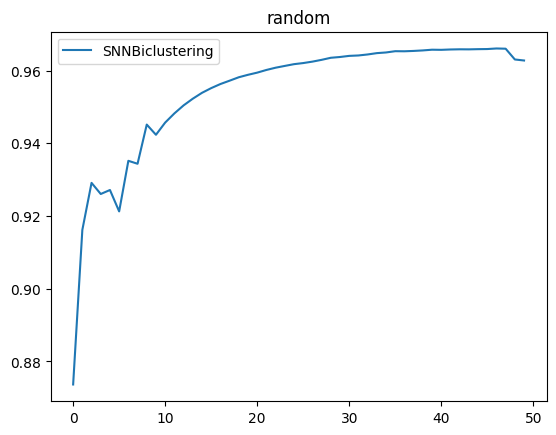

In [4]:
algorithms = ["SNNBiclustering"]
chunksize = [10]
datasize = 500
drifts = []
repeat = 1
for k, data_assignment in enumerate(datasets_assignment_generators[:]):
    if k != 2: continue
    plt.figure()
    plt.title(data_names[k])
    for alg in algorithms:
            for chunk_size in chunksize:
                ## Temp solution for mask problem
                r2_scores, model, cusum = evaluate_partial(
                    data_gen,
                    data_assignment,
                    alg,
                    repeat,
                    datasize,
                    chunk_size,
                    drifts
                )
                print(f"Evaluate {alg} for {data_names[k]}")
                plt.plot(r2_scores.mean(1), label = alg)
    plt.legend()
            
                




### 2. No drift, Large chunk updates

Generated 394 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12b176730>] [(0, 0.005400478801521651)] 100
[(100, 5), (100, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x12b176730>] [(0, 0.005400478801521651)] 200
[(100, 5), (200, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x12b176730>] [(0, 0.005400478801521651)] 300
[(100, 5), (300, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x12b176730>] [(0, 0.005400478801521651)] 400
[(100, 5), (400, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x12b176730>] [(0, 0.005400478801521651)] 500
[(100, 5), (500, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x12b176730>] [(0, 0.005400478801521651)] 600
[(100, 5), (600, 5), (3, 5)]
Evaluate SNNBiclustering for random


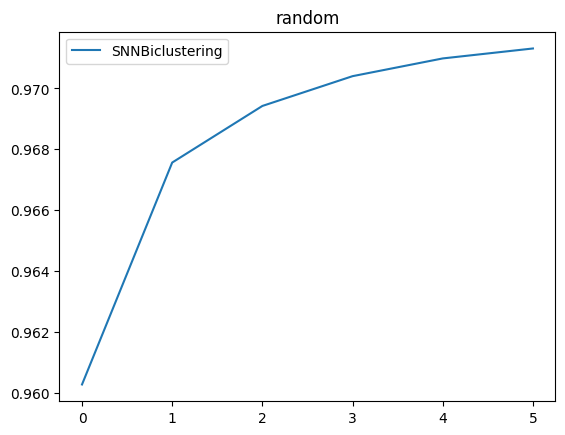

In [5]:

chunksize = [100]
datasize = 600
drifts = []
repeat = 1
for k, data_assignment in enumerate(datasets_assignment_generators[:]):
    if k != 2: continue
    plt.figure()
    plt.title(data_names[k])
    for alg in algorithms:
            for chunk_size in chunksize:
                ## Temp solution for mask problem
                r2_scores, model, cusum = evaluate_partial(
                    data_gen,
                    data_assignment,
                    alg,
                    repeat,
                    datasize,
                    chunk_size,
                    drifts
                )
                print(f"Evaluate {alg} for {data_names[k]}")
                plt.plot(r2_scores.mean(1), label = alg)
    plt.legend()
            
                




### 3. Single drift

Generated 400 clusters
[<algorithms.fill_tensor_base.Regime object at 0x131727670>] [(0, 0.003170594976796197)] 100
[(100, 5), (100, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x131727670>] [(0, 0.003170594976796197)] 200
[(100, 5), (200, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x131727670>] [(0, 0.003170594976796197)] 300
[(100, 5), (300, 5), (3, 5)]
Generated 400 clusters
[<algorithms.fill_tensor_base.Regime object at 0x131727670>, <algorithms.fill_tensor_base.Regime object at 0x13180aa60>] [(0, 0.003170594976796197), (303, 0.0054692752777813405)] 400
[(100, 5), (303, 5), (3, 5)]
Generated 413 clusters
[<algorithms.fill_tensor_base.Regime object at 0x131727670>, <algorithms.fill_tensor_base.Regime object at 0x13180aa60>] [(0, 0.003170594976796197), (303, 0.004199931172500358)] 500
[(100, 5), (303, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x131727670>, <algorithms.fill_tensor_base.Regime object at 0x13180aa60>] [(0, 0.00317059497679

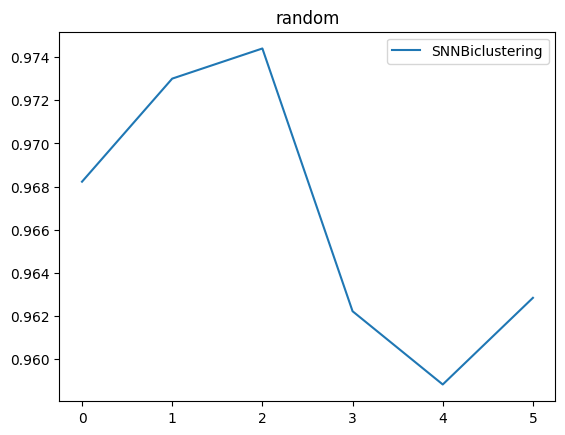

In [6]:
chunksize = [100]
datasize = 600
drifts = [300]
repeat = 1
for k, data_assignment in enumerate(datasets_assignment_generators[:]):
    if k != 2: continue
    plt.figure()
    plt.title(data_names[k])
    for alg in algorithms:
            for chunk_size in chunksize:
                ## Temp solution for mask problem
                r2_scores, model, cusum = evaluate_partial(
                    data_gen,
                    data_assignment,
                    alg,
                    repeat,
                    datasize,
                    chunk_size,
                    drifts
                )
                print(f"Evaluate {alg} for {data_names[k]}")
                plt.plot(r2_scores.mean(1), label = alg)
    plt.legend()
            
                




### 4. Multiple drifts

Generated 400 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12b66d460>] [(0, 0.0041414893318242165)] 100
[(100, 5), (100, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x12b66d460>] [(0, 0.0041414893318242165)] 200
[(100, 5), (200, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x12b66d460>] [(0, 0.0041414893318242165)] 300
[(100, 5), (300, 5), (3, 5)]
[<algorithms.fill_tensor_base.Regime object at 0x12b66d460>] [(0, 0.0041414893318242165)] 400
[(100, 5), (400, 5), (3, 5)]
Generated 404 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12b66d460>, <algorithms.fill_tensor_base.Regime object at 0x131810340>] [(0, 0.0041414893318242165), (410, 0.004560634434685863)] 500
[(100, 5), (410, 5), (3, 5)]
Generated 414 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12b66d460>, <algorithms.fill_tensor_base.Regime object at 0x131810340>] [(0, 0.0041414893318242165), (410, 0.0037789612515476754)] 600
[(100, 5), (410, 5), (3, 5)]
[<algorithms.f

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[<algorithms.fill_tensor_base.Regime object at 0x12b66d460>, <algorithms.fill_tensor_base.Regime object at 0x131810340>, <algorithms.fill_tensor_base.Regime object at 0x12af44fd0>] [(0, 0.0041414893318242165), (410, 0.0037789612515476754), (809, 0.0047908897087962955)] 1200
[(100, 5), (410, 5), (3, 5)]
Evaluate SNNBiclustering for random


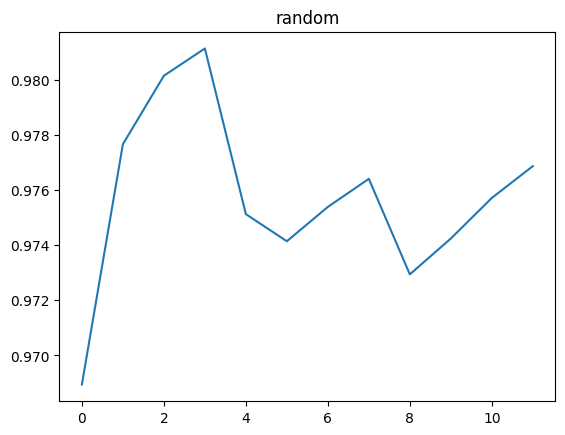

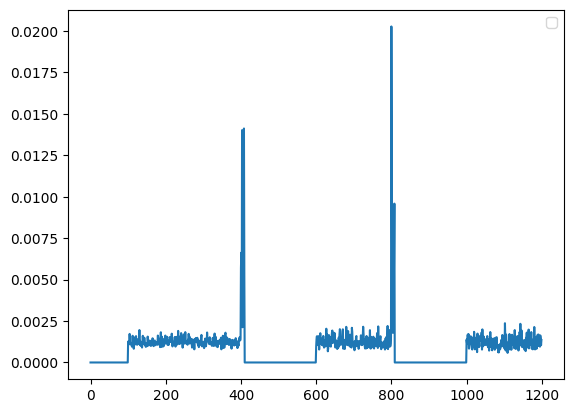

In [7]:
chunksize = [100]
datasize = 1200
drifts = [400, 800]
repeat = 1
for k, data_assignment in enumerate(datasets_assignment_generators[:]):
    if k != 2: continue
    plt.figure()
    plt.title(data_names[k])
    for alg in algorithms:
            for chunk_size in chunksize:
                ## Temp solution for mask problem
                r2_scores, model, cusum = evaluate_partial(
                    data_gen,
                    data_assignment,
                    alg,
                    repeat,
                    datasize,
                    chunk_size,
                    drifts
                )
                print(f"Evaluate {alg} for {data_names[k]}")
                plt.plot(r2_scores.mean(1), label = alg)
                plt.figure()
                plt.plot(model.distance_error)
    plt.legend()
            
                




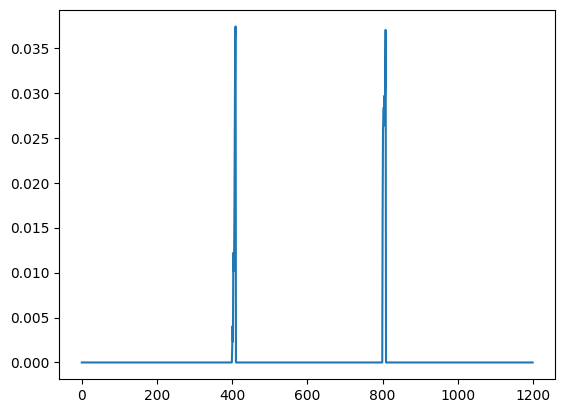

In [8]:
plt.plot(model.cusum)

## 5. very small update test

Generated 37 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12abc1ee0>] [(0, 3.754919256669728e-12)] 5
[(10, 5), (5, 5), (3, 5)]
Generated 42 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12abc1ee0>] [(0, 0.0024630018189533854)] 10
[(10, 5), (10, 5), (3, 5)]
Generated 41 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12abc1ee0>] [(0, 0.013934416915853134)] 15
[(10, 5), (15, 5), (3, 5)]
Generated 46 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12abc1ee0>] [(0, 0.0063540268978511515)] 20
[(10, 5), (20, 5), (3, 5)]
Generated 50 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12abc1ee0>] [(0, 0.014489007879407951)] 25
[(10, 5), (25, 5), (3, 5)]
Generated 42 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12abc1ee0>] [(0, 0.023107945708153912)] 30
[(10, 5), (30, 5), (3, 5)]
Generated 52 clusters
[<algorithms.fill_tensor_base.Regime object at 0x12abc1ee0>] [(0, 0.015375254873211142)] 35
[(10, 5), (35, 5), (3, 5)]
Generated 49

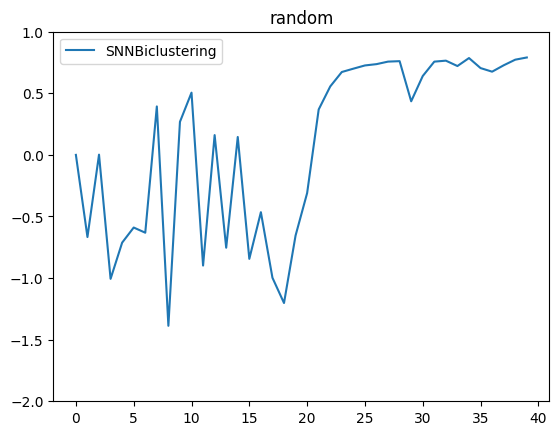

In [11]:


chunksize = [5]
datasize = 200
drifts = [140]
repeat = 1
for k, data_assignment in enumerate(datasets_assignment_generators[:]):
    if k != 2: continue
    plt.figure()
    plt.title(data_names[k])
    for alg in algorithms:
            for chunk_size in chunksize:
                ## Temp solution for mask problem
                r2_scores, model, cusum = evaluate_partial(
                    data_gen,
                    data_assignment,
                    alg,
                    repeat,
                    datasize,
                    chunk_size,
                    drifts,
                    no_units = 10
                )
                print(f"Evaluate {alg} for {data_names[k]}")
                plt.plot(r2_scores.mean(1), label = alg)
    plt.legend()
    plt.ylim([-2,1])
                 


